In [41]:
import sys
# syspath = 'D:/Research_CAE/MyTinyCUDANN/tiny-cuda-nn/my_job'
syspath = 'D:/Research_CAE/MyTinyCUDANN/tiny-cuda-nn/main'
sys.path.append(syspath)
from my_tiny_cuda import my_MLP,my_sin,weights_init_uniform,grad1
from my_tiny_cuda import my_rmse,plot_diff,plot_result_ele,my_relativeL2,my_sig,plot_result_node

from my_tiny_cuda import fdiff2 as fdiff

from tools import random_points_1D,random_points_2D


import os
import torch
import numpy as np
import time
from matplotlib import pyplot as plt
import matplotlib.colors as colors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_dtype = torch.float32

In [42]:
class strong_form(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def f(self,x,y):
        result = torch.exp(-x)*(x-2+y**3+6*y)
        return result
    def forward(self,X,d2u_dx2,d2u_dy2):
        x,y = X[:,0],X[:,1]
        result = d2u_dx2 + d2u_dy2 - self.f(x,y)
        return result

class BC_function(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        x,y = X[:,0],X[:,1]
        result = torch.exp(-x)*(x+y**3)
        return result
true_func = BC_function()

In [43]:
activation, activation_name = torch.nn.Tanh(),"Tanh"
# activation, activation_name = torch.nn.SiLU(),"SiLU"
# activation, activation_name = my_sin(), "Sin"
n_hidden = 5
width = 64
mlp = my_MLP(activation=activation,n_input_dims=2,
             n_output_dims=1,n_hidden = n_hidden,width = width,
             spectral_norm=False,dtype = my_dtype).to(device)
if activation_name == "Sin":
    mlp.apply(weights_init_uniform)


model = mlp

MSE = torch.nn.MSELoss().to(device)
MAE = torch.nn.L1Loss().to(device)

print("done")

done


In [44]:
batch_size_BC = 2000
field_min,field_max = 0,1

n00 = torch.tensor([0,0])
n01 = torch.tensor([0,1])
n10 = torch.tensor([1,0])
n11 = torch.tensor([1,1])
X_bot = random_points_1D(int(batch_size_BC/4),n00,n10)
X_left = random_points_1D(int(batch_size_BC/4),n00,n01)
X_right = random_points_1D(int(batch_size_BC/4),n10,n11)
X_top = random_points_1D(int(batch_size_BC/4),n01,n11)
X_boundaries = torch.cat((X_bot,X_left,X_top,X_right), dim = 0)
X_boundaries.shape

torch.Size([2000, 2])

In [45]:
resolution = 501
field_min,field_max = 0,1
x1_list = np.linspace(field_min, field_max, resolution)
x2_list = np.linspace(field_min, field_max, resolution)
X1,X2 = np.meshgrid(x1_list,x2_list)
X_field = torch.tensor(np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis = 1)).float().cuda()

u_real = true_func(X_field).to('cpu').detach().numpy()
u_real_plot = u_real.reshape(resolution,resolution)

In [46]:
n_steps = 6000
n_step_output = 600
n_step_half_lr = 500

X_I_res = 300
batch_size = X_I_res**2
lam = 5000
X_I = torch.rand([batch_size, 2],dtype=my_dtype, device = 'cuda')

# optimizer,optimizer_name = torch.optim.Adam([
#     {'params':model.parameters(),'weight_decay':1e-6},
# ], lr=0.005, eps=1e-15), "Adam"

max_iter = 600
optimizer,optimizer_name = torch.optim.LBFGS(model.parameters(), lr=1e-1, 
                              max_iter=max_iter, max_eval=max_iter, history_size=50,
                              #tolerance_grad=1e-5, tolerance_change=0.5 * np.finfo(float).eps,
                              line_search_fn="strong_wolfe"), "LBFGS"

if optimizer_name == "Adam":
    n_steps = n_steps
    n_step_output = n_step_output
    n_step_half_lr = n_step_half_lr
elif optimizer_name == "LBFGS":
    n_steps = int(n_steps/max_iter)
    n_step_output = max(int(n_step_output/max_iter),1)
    n_step_half_lr = max(int(n_step_half_lr/max_iter),1)

PDE = strong_form()
pretrain_func = BC_function()
f_boundaries = pretrain_func(X_boundaries)

diff_info = fdiff(model, batch_size)
diff_info.to_device("cuda")

model.train()
start = time.time()
test_loss = []
for i in range(1, n_steps+1):
    def closure():
        global inner_loss
        optimizer.zero_grad()
        # Boundary
        bc_loss = MSE(model(X_boundaries),f_boundaries)
        # Inner
        # X_I = torch.rand([batch_size, 2],dtype=my_dtype, device = 'cuda')

        diff_res = diff_info.forward(X_I)


        PDE_residual = PDE(X_I, d2u_dx2 = diff_res['u_xx'],d2u_dy2 = diff_res['u_yy'])
        inner_loss = (PDE_residual**2).mean()
        loss = inner_loss + lam * bc_loss
        loss.backward()
        return loss
    
    optimizer.step(closure)
           

    if i%n_step_output == 0:
        model.eval()
        with torch.no_grad():
            u_pred = model(X_field).to('cpu').detach().numpy()
            #u_pred_plot = u_pred.reshape(resolution,resolution)
            u_error = my_relativeL2(u_pred,u_real)
            pred_bc = model(X_boundaries)
            loss_bc = MSE(pred_bc,f_boundaries)
        print('Iter:',i,'inner_loss:',inner_loss.item(),"\n",
              'bc_loss:',loss_bc.item(),'u_L2:',u_error,)
        test_loss.append([time.time()-start, i,u_error])
        model.train()

    if i%n_step_half_lr == 0:
        for _ in optimizer.param_groups:
            _['lr'] = _['lr']/2

end = time.time()
end-start

Iter: 1 inner_loss: 0.0032500624656677246 
 bc_loss: 9.770764108907315e-08 u_L2: 0.00096455286
Iter: 2 inner_loss: 0.0021074539981782436 
 bc_loss: 6.21067073325321e-08 u_L2: 0.00064360077
Iter: 3 inner_loss: 0.0010506586404517293 
 bc_loss: 3.3431891921509305e-08 u_L2: 0.0010773914
Iter: 4 inner_loss: 0.0006840329733677208 
 bc_loss: 1.960912499043843e-08 u_L2: 0.0005941087
Iter: 5 inner_loss: 0.0006837392575107515 
 bc_loss: 1.945644534373514e-08 u_L2: 0.0005903269
Iter: 6 inner_loss: 0.0006837393157184124 
 bc_loss: 1.945644534373514e-08 u_L2: 0.0005903269
Iter: 7 inner_loss: 0.0006837393157184124 
 bc_loss: 1.945644534373514e-08 u_L2: 0.0005903269
Iter: 8 inner_loss: 0.0006837393157184124 
 bc_loss: 1.945644534373514e-08 u_L2: 0.0005903269
Iter: 9 inner_loss: 0.0006837393157184124 
 bc_loss: 1.945644534373514e-08 u_L2: 0.0005903269
Iter: 10 inner_loss: 0.0006837390828877687 
 bc_loss: 1.9456100730508297e-08 u_L2: 0.0005901954


101.06154775619507

In [47]:
np.savetxt("data/PINN({}).txt".format(activation_name), np.array(test_loss))
# np.savetxt("onephase_lam/Lam={}.txt".format(lam), np.array(test_loss))
# np.savetxt("data/Poisson_allpbc_n_width={}.txt".format(width), np.array(test_loss))
# np.savetxt("data/grid_two_phase_n_hidden={}_width={}.txt".format(n_hidden,width), np.array(test_loss))

In [48]:
model.eval()
torch.no_grad()
pred = model(X_field).to('cpu').detach().numpy().reshape(resolution,resolution)

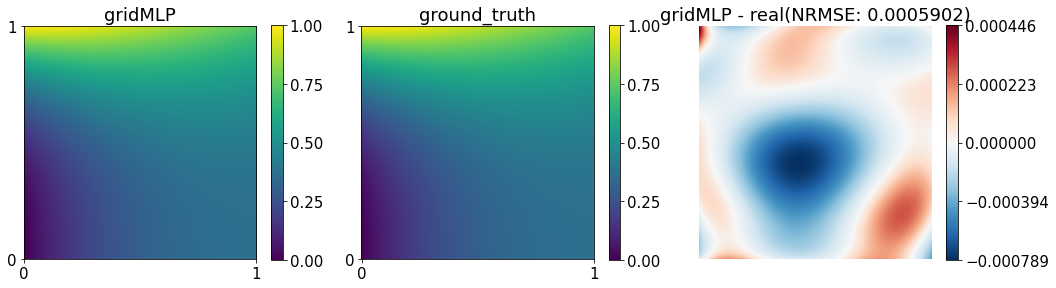

In [49]:
ifsave = False
plot_diff(pred,u_real_plot,field_name = "gridMLP",f_name = '',ifsave = ifsave)

In [50]:
# plot_result_node(f = pred_v,f0 = ground_truth_v,x = (x1,x2),mesh = tri,name = "uy",f_name = 'uy',ifsave = ifsave)

In [51]:
# #Points for plot
# resolution = 2501
# field_min,field_max = 0,1
# x1_list = np.linspace(field_min, field_max, resolution)
# x2_list = np.linspace(field_min, field_max, resolution)
# X1,X2 = np.meshgrid(x1_list,x2_list)
# X_field = torch.tensor(np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis = 1)).float().cuda()


# in_hole = ((X_field[:,0]**2+X_field[:,1]**2-r_hole**2)<=0).to('cpu').numpy().reshape(resolution,resolution)
# disp_x = modelu(X_field)
# disp_x = disp_x.to('cpu').detach().numpy().reshape(resolution,resolution)


# dux_dx = np.diff(disp_x)*(resolution-1)
# dux_dx[in_hole[:,:-1]] = 0

# X1_diffx = torch.tensor(X1[:,:-1]+1/(resolution-1)/2)
# X2_diffx = torch.tensor(X2[:,:-1])
# real_exx = domain.strain_tensor(X1_diffx,X2_diffx)[0].numpy()
# real_exx[in_hole[:,:-1]] = 0

In [52]:
# disp_y = modelv(X_field)
# disp_y = disp_y.to('cpu').detach().numpy().reshape(resolution,resolution)


# duy_dy = np.diff(disp_y,axis = 0)*(resolution-1)
# duy_dy[in_hole[:-1,:]] = 0

# X1_diffy = torch.tensor(X1[:-1,:])
# X2_diffy = torch.tensor(X2[:-1,:]+1/(resolution-1)/2)
# real_eyy = domain.strain_tensor(X1_diffy,X2_diffy)[1].numpy()
# real_eyy[in_hole[:-1,:]] = 0

In [53]:
# ifsave_FDM = False
# plot_diff(dux_dx,real_exx,"exx_FDM","diff_exx_fdm",ifsave = ifsave_FDM)

In [54]:
# plot_diff(duy_dy,real_eyy,"eyy_FDM","diff_eyy_fdm",ifsave = ifsave_FDM)

In [55]:
# disp_y = modelv(X_field)
# # disp_y[(X_field[:,0]**2+X_field[:,1]**2-r_hole**2)<=0] = 0
# disp_y = disp_y.to('cpu').detach().numpy().reshape(resolution,resolution)
# duy_dy = np.diff(disp_y,axis = 0)*(resolution-1)
# duy_dy[in_hole[:-1,:]] = 0
# plt.imshow(duy_dy,origin = 'lower',vmin = -0.1,vmax = 0.01)
# plt.colorbar()
# plt.title("eyy_finite_diff")
# plt.savefig('figs/eyy_finite_diff.jpg', dpi = 500)

In [56]:
# ifsave = False
# plot_diff(u_plot,ground_truth_u_plot,"ux","diff_ux_gridsample",ifsave = ifsave)

In [57]:
# plot_diff(v_plot,ground_truth_v_plot,"uy","diff_uy_gridsample",ifsave = ifsave)

In [58]:
# X1_autodiff = torch.tensor(X1[:-1,:-1]+1/(resolution-1)/2)
# X2_autodiff = torch.tensor(X2[:-1,:-1]+1/(resolution-1)/2)
# in_hole_autodiff = ((X1_autodiff**2+X2_autodiff**2-r_hole**2)<=0).to('cpu').numpy().reshape(resolution-1,resolution-1)

# X_IP = torch.cat((X1_autodiff.reshape(-1,1),X2_autodiff.reshape(-1,1)),axis = 1).float().cuda()

# point_num = X_IP.shape[0]
# pred_e11_IP = np.zeros(point_num)
# pred_e12_IP = np.zeros(point_num)
# pred_e22_IP = np.zeros(point_num)
# plot_batch_size = 100000

# # diff_info_plot = grad1(model, plot_batch_size)
# i_batch = 0
# i_1 = 0
# for X_plot_batch in X_IP.split(plot_batch_size):
#     i_1 = i_batch+X_plot_batch.shape[0]
#     e11_IP,e12_IP = diff_info_u.forward_2d_plot(X_plot_batch)
#     e21_IP,e22_IP = diff_info_v.forward_2d_plot(X_plot_batch)
#     # e11_IP,e12_IP,e21_IP,e22_IP =diff_info_plot.forward_2d_uv_plot(X_plot_batch)

#     e11_IP = e11_IP.to('cpu').detach().numpy()
#     e22_IP = e22_IP.to('cpu').detach().numpy()
#     e12_IP = ((e12_IP+e21_IP)/2).to('cpu').detach().numpy()
    
#     pred_e11_IP[i_batch:i_1] = e11_IP
#     pred_e12_IP[i_batch:i_1] = e12_IP
#     pred_e22_IP[i_batch:i_1] = e22_IP
    
#     i_batch = i_1
#     print(i_batch,point_num)
    
# # rmse_e11 = my_rmse(pred_e11_IP, true_e11_IP)
# # rmse_e22 = my_rmse(pred_e22_IP, true_e22_IP)
# # rmse_e12 = my_rmse(pred_e12_IP, true_e12_IP)

# # rmse_e11 = float(np.format_float_positional(rmse_e11,precision = 3,unique=False, fractional=False, trim='k'))
# # rmse_e22 = float(np.format_float_positional(rmse_e22,precision = 3,unique=False, fractional=False, trim='k'))
# # rmse_e12 = float(np.format_float_positional(rmse_e12,precision = 3,unique=False, fractional=False, trim='k'))

# # x1 = np.loadtxt(real_path + "x1_plot.txt")
# # x2 = np.loadtxt(real_path + "x2_plot.txt")
# # tri = np.loadtxt(real_path + "tri_plot.txt")

In [59]:

# # e11_IP,e12_IP = diff_info_u.forward_2d_plot(X_IP)
# # e21_IP,e22_IP = diff_info_v.forward_2d_plot(X_IP)

# # pred_e11_IP = e11_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)
# # pred_e22_IP = e22_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)
# # pred_e12_IP = ((e12_IP+e21_IP)/2).to('cpu').detach().numpy().reshape(resolution-1,resolution-1)


# pred_e11_IP = pred_e11_IP.reshape(resolution-1,resolution-1)
# pred_e22_IP = pred_e22_IP.reshape(resolution-1,resolution-1)
# pred_e12_IP = pred_e12_IP.reshape(resolution-1,resolution-1)

# pred_e11_IP[in_hole_autodiff] = 0
# pred_e22_IP[in_hole_autodiff] = 0
# pred_e12_IP[in_hole_autodiff] = 0

# true_e11_IP,true_e22_IP,true_e12_IP = domain.strain_tensor(X_IP[:,0],X_IP[:,1])
# true_e11_IP = true_e11_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)
# true_e22_IP = true_e22_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)
# true_e12_IP = true_e12_IP.to('cpu').detach().numpy().reshape(resolution-1,resolution-1)

# true_e11_IP[in_hole_autodiff] = 0
# true_e22_IP[in_hole_autodiff] = 0
# true_e12_IP[in_hole_autodiff] = 0

In [60]:
# ifsave = False
# plot_diff(pred_e11_IP,true_e11_IP,"exx_autodiff","diff_exx_autodiff",ifsave = ifsave)

In [61]:
# plot_diff(pred_e22_IP,true_e22_IP,"eyy_autodiff","diff_eyy_autodiff",ifsave = ifsave)

In [62]:
# IP_x = np.loadtxt(real_path + "IP_x.txt")
# IP_y = np.loadtxt(real_path + "IP_y.txt")
# X_nodes = torch.tensor(np.concatenate([IP_x.reshape(-1,1),IP_y.reshape(-1,1)]
#                                    ,axis = 1)).float().cuda()

In [63]:
# e11_nodes,e12_nodes = diff_info_u.forward_2d_plot(X_nodes)
# e21_nodes,e22_nodes = diff_info_v.forward_2d_plot(X_nodes)

# pred_e11_nodes = e11_nodes.to('cpu').detach().numpy()
# pred_e22_nodes = e22_nodes.to('cpu').detach().numpy()
# pred_e12_nodes = ((e12_nodes+e21_nodes)/2).to('cpu').detach().numpy()

# true_e11_nodes,true_e22_nodes,true_e12_nodes = domain.strain_tensor(X_nodes[:,0],X_nodes[:,1])
# true_e11_nodes = true_e11_nodes.to('cpu').detach().numpy()
# true_e22_nodes = true_e22_nodes.to('cpu').detach().numpy()
# true_e12_nodes = true_e12_nodes.to('cpu').detach().numpy()

In [64]:
# ifsave = False
# plot_result_ele(f = pred_e11_nodes,f0 = true_e11_nodes,x = (x1,x2),mesh = tri,name = "exx",f_name = 'exx',ifsave = ifsave)

In [65]:
# plot_result_ele(f = pred_e12_nodes,f0 = true_e12_nodes,x = (x1,x2),mesh = tri,name = "exy",f_name = 'exy',ifsave = ifsave)

In [66]:
# plot_result_ele(f = pred_e22_nodes,f0 = true_e22_nodes,x = (x1,x2),mesh = tri,name = "eyy",f_name = 'eyy',ifsave = ifsave)

In [67]:
# modelu.eval()
# modelv.eval()
# torch.no_grad()
# resolution = 501
# eps = boundary_min
# field_min,field_max = eps,1-eps
# x1_list = np.linspace(field_min, field_max, resolution)
# x2_list = np.linspace(field_min, field_max, resolution)
# X1,X2 = np.meshgrid(x1_list,x2_list)
# X_field = torch.tensor(np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis = 1)).float().cuda()

# plot_batch = X_field.shape[0]
# diff_info_u = grad1(modelu, plot_batch)
# diff_info_v = grad1(modelv, plot_batch)
# u_x,u_y = diff_info_u.forward_2d(X_field)
# v_x,v_y = diff_info_v.forward_2d(X_field)
# ux_plot = u_x.to('cpu').detach().numpy().reshape(resolution,resolution)
# vy_plot = v_y.to('cpu').detach().numpy().reshape(resolution,resolution)
# tao_xy_plot = (0.5*(u_y.detach()+v_x.detach())).to('cpu').numpy().reshape(resolution,resolution)

In [68]:
# plt.figure(figsize=(16,4))

# plt.subplot(131)
# fmax = float(np.format_float_positional(ux_plot.max(),precision = 3,unique=False, fractional=False, trim='k'))
# fmin = float(np.format_float_positional(ux_plot.min(),precision = 3,unique=False, fractional=False, trim='k'))
# interval = (fmax-fmin)/4
# ct = (fmin, fmin + interval, fmin + 2*interval, fmin + 3*interval, fmax)
# plt.imshow(ux_plot,origin = 'lower',norm=colors.TwoSlopeNorm(vcenter=ct[2],vmin = ct[0],vmax = ct[-1]),
#           interpolation = None)
# # plt.imshow(f_plot,origin = 'lower',interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.colorbar(ticks=ct)
# plt.axis('off')
# plt.title('exx (rmse:{})'.format(rmse_e11))

# plt.subplot(132)
# fmax = float(np.format_float_positional(vy_plot.max(),precision = 3,unique=False, fractional=False, trim='k'))
# fmin = float(np.format_float_positional(vy_plot.min(),precision = 3,unique=False, fractional=False, trim='k'))
# interval = (fmax-fmin)/4
# ct = (fmin, fmin + interval, fmin + 2*interval, fmin + 3*interval, fmax)
# plt.imshow(vy_plot,origin = 'lower',norm=colors.TwoSlopeNorm(vcenter=ct[2],vmin = ct[0],vmax = ct[-1]),
#           interpolation = None)
# # plt.imshow(f_plot,origin = 'lower',interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.colorbar(ticks=ct)
# plt.axis('off')
# plt.title('eyy (rmse:{})'.format(rmse_e22))

# plt.subplot(133)
# fmax = float(np.format_float_positional(tao_xy_plot.max(),precision = 3,unique=False, fractional=False, trim='k'))
# fmin = float(np.format_float_positional(tao_xy_plot.min(),precision = 3,unique=False, fractional=False, trim='k'))
# interval = (fmax-fmin)/4
# ct = (fmin, fmin + interval, fmin + 2*interval, fmin + 3*interval, fmax)
# plt.imshow(tao_xy_plot,origin = 'lower',norm=colors.TwoSlopeNorm(vcenter=ct[2],vmin = ct[0],vmax = ct[-1]),
#           interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.colorbar(ticks=ct)
# plt.axis('off')
# plt.title('exy (rmse:{})'.format(rmse_e12))
# fig.tight_layout()
# # plt.savefig('figs/fiber_eps_2grid.jpg',dpi = 300)
# plt.show()

In [69]:
# np.savetxt("results_data/tinyfix_w50.txt", f_plot)

In [70]:
# n_plots = 6
# torch.no_grad()
# field_y = encoding_v(X_field.to(device)).to('cpu').detach().numpy()
# plot_levels = np.linspace(0,n_levels-1,n_plots).astype('int')
# plt.figure(figsize=(14,8))

# for level,i in zip(plot_levels,range(n_plots)):
#     plt.subplot(2,3,i+1)
#     f_plot = field_y[:,level*n_features].reshape(resolution,resolution)
#     fmax = f_plot.max()
#     fmin = f_plot.min()
#     interval = (fmax-fmin)/4
#     ct = (my_sig(fmin,2), my_sig(fmin + interval,2), my_sig(fmin + 2*interval,2), my_sig(fmin + 3*interval,2), my_sig(fmax,2))    
#     plt.imshow(f_plot,origin = 'lower',interpolation = None,vmin=my_sig(fmin,2), vmax=my_sig(fmax,2))

#     plt.xticks([0,resolution],[0,1])
#     plt.yticks([0,resolution],[0,1])
#     plt.axis('off')
#     res = np.floor(np.power(p_l_s, float(level), dtype="d")*base_res-1, dtype="d").astype(int)+1
#     plt.title("level = {}, res = {}".format(level+1,res))
#     plt.colorbar(ticks=ct)

# # plt.savefig('figs/feature_output.jpg',dpi = 1500)
# plt.show()

In [71]:
# n_plots = 6
# X_field_grad = X_field.to(device).clone()
# X_field_grad.requires_grad = True
# field_y = encoding_v(X_field_grad)
# plot_levels = np.linspace(0,n_levels-1,n_plots).astype('int')
# plt.figure(figsize=(14,8))

# for level,i in zip(plot_levels,range(n_plots)):
#     plt.subplot(2,3,i+1)
#     f_plot_disp = field_y[:,level*n_features]#.reshape(resolution,resolution)
#     f_plot = grad(f_plot_disp,X_field_grad,
#                        torch.ones_like(f_plot_disp).to(device),
#                        retain_graph=True, create_graph=True)[0][:,1].reshape(resolution,resolution).to('cpu').detach().numpy()[1:-1,1:-1]
#     fmax = f_plot.max()
#     fmin = f_plot.min()
#     interval = (fmax-fmin)/4
#     ct = (my_sig(fmin,2), my_sig(fmin + interval,2), my_sig(fmin + 2*interval,2), my_sig(fmin + 3*interval,2), my_sig(fmax,2))    
#     plt.imshow(f_plot,origin = 'lower',interpolation = None,vmin=my_sig(fmin,2), vmax=my_sig(fmax,2))

# #     plt.xticks([0,resolution],[xmin,xmax])
# #     plt.yticks([0,resolution],[ymin,ymax])
#     plt.axis('off')
#     res = np.floor(np.power(p_l_s, float(level), dtype="d")*base_res-1, dtype="d").astype(int)+1
#     plt.title("level = {}, res = {}".format(level+1,res))
#     plt.colorbar(ticks=ct)

# plt.show()

In [72]:
# n_plots = 6
# X_field_grad = X_field.to(device).clone()
# X_field_grad.requires_grad = True
# f_plot_feature = encoding_u(X_field_grad)
# f_plot_disp = mlp(f_plot_feature)
# f_plot_all = grad(f_plot_disp,f_plot_feature,
#                    torch.ones_like(f_plot_disp).to(device),
#                    retain_graph=True, create_graph=True)[0]
# plot_levels = np.linspace(0,n_levels-1,n_plots).astype('int')
# plt.figure(figsize=(14,8))

# for level,i in zip(plot_levels,range(n_plots)):
#     plt.subplot(2,3,i+1)    
#     f_plot = f_plot_all[:,level*n_features].reshape(resolution,resolution).to('cpu').detach().numpy()
#     fmax = f_plot.max()
#     fmin = f_plot.min()
#     interval = (fmax-fmin)/4
#     ct = (my_sig(fmin,2), my_sig(fmin + interval,2), my_sig(fmin + 2*interval,2), my_sig(fmin + 3*interval,2), my_sig(fmax,2))    
#     plt.imshow(f_plot,origin = 'lower',interpolation = None,vmin=my_sig(fmin,2), vmax=my_sig(fmax,2))

#     plt.xticks([0,resolution],[xmin,xmax])
#     plt.yticks([0,resolution],[ymin,ymax])
#     plt.axis('off')
#     res = np.floor(np.power(p_l_s, float(level), dtype="d")*base_res-1, dtype="d").astype(int)+1
#     plt.title("level = {}, res = {}".format(level+1,res))
#     plt.colorbar(ticks=ct)

# plt.show()
# f_plot_all.to('cpu').detach().numpy().mean(axis = 0)

In [73]:
# n_plots = 6
# X_field_grad = X_field.to(device).clone()
# X_field_grad.requires_grad = True

# f_plot_feature = encoding_u(X_field_grad)
# f_plot_disp = mlp(f_plot_feature)
# dm_dh = grad(f_plot_disp,f_plot_feature,
#                    torch.ones_like(f_plot_disp).to(device),
#                    retain_graph=True, create_graph=True)[0].to('cpu').detach()
# dh_dx1 = torch.zeros_like(dm_dh)
# for level in range(n_plots):
#     dhi_dx1 = grad(f_plot_feature[:,level],X_field_grad,
#                        torch.ones_like(f_plot_feature[:,level]).to(device),
#                        retain_graph=True, create_graph=True)[0][:,0].to('cpu').detach()
#     dh_dx1[:,level] = dhi_dx1

# f_plot = (dm_dh*dh_dx1).sum(axis = 1).reshape(resolution,resolution).numpy()

# plt.figure(figsize=(6,6))

# fmax = f_plot.max()
# fmin = f_plot.min()
# interval = (fmax-fmin)/4
# ct = (my_sig(fmin,2), my_sig(fmin + interval,2), my_sig(fmin + 2*interval,2), my_sig(fmin + 3*interval,2), my_sig(fmax,2))    
# plt.imshow(f_plot,origin = 'lower',interpolation = None,vmin=my_sig(fmin,2), vmax=my_sig(fmax,2))

# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.axis('off')
# plt.colorbar(ticks=ct)

# plt.show()

In [74]:
# target_level = 12
# # encoding.eval()
# torch.no_grad()
# field_y = encoding_u(X_field.to(device)).to('cpu').detach().numpy()
# plt.figure(figsize=(10,8))
# if target_level != 0:
#     plt.subplot(2,2,1)
#     f_plot = field_y[:,target_level*n_features - 1].reshape(resolution,resolution)
#     plt.imshow(f_plot,origin = 'lower',interpolation = None)
#     plt.xticks([0,resolution],[xmin,xmax])
#     plt.yticks([0,resolution],[ymin,ymax])
#     plt.axis('off')
#     plt.title("level = {}, F = {}".format(target_level,2))
#     plt.colorbar()

# plt.subplot(2,2,2)
# f_plot = field_y[:,target_level*n_features].reshape(resolution,resolution)
# plt.imshow(f_plot,origin = 'lower',interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.axis('off')
# plt.title("level = {}, F = {}".format(target_level+1,1))
# plt.colorbar()
# plt.subplot(2,2,3)
# f_plot = field_y[:,(target_level+1)*n_features -1].reshape(resolution,resolution)
# plt.imshow(f_plot,origin = 'lower',interpolation = None)
# plt.xticks([0,resolution],[xmin,xmax])
# plt.yticks([0,resolution],[ymin,ymax])
# plt.axis('off')
# plt.title("level = {}, F = {}".format(target_level+1,2))
# plt.colorbar()
# if target_level != n_levels-1:
#     plt.subplot(2,2,4)
#     f_plot = field_y[:,(target_level+1)*n_features].reshape(resolution,resolution)
#     plt.imshow(f_plot,origin = 'lower',interpolation = None)
#     plt.xticks([0,resolution],[xmin,xmax])
#     plt.yticks([0,resolution],[ymin,ymax])
#     plt.axis('off')
#     plt.title("level = {}, F = {}".format(target_level+2,1))
#     plt.colorbar()

# plt.show()